# 获得标定板在相机坐标系下的位姿

假设现在完成了相机标定，接下里想通过采集到的标定板的图像来获取标定板在相机坐标系下的位姿$^{cam}_{board}T$


In [1]:
import yaml
import numpy as np
from matplotlib import pyplot as plt
import cv2
# 自定义库
from transform import Transform
from pose import Pose

np.set_printoptions(precision=4, suppress=True)

## 载入标定板配置文件



In [2]:
with open('config/camera_calibration.yaml', 'r', encoding='utf-8') as f:
    config = yaml.load(f.read(), Loader=yaml.SafeLoader)
n_row = config['caliboard']['row']
n_column = config['caliboard']['column']
n_corner = n_row*n_column

##  获取角点在标定板坐标系上的坐标

In [3]:
# 行与列的索引号
x, y = np.meshgrid(range(n_row), range(n_column))
# 标定板角点在标定板坐标系下的坐标
world_points = np.hstack((x.reshape(n_corner, 1), y.reshape(n_corner, 1), np.zeros((n_corner, 1)))).astype(np.float64)
world_points *= config["caliboard"]["ceil_size"]

In [4]:
print(world_points)

[[  0.    0.    0. ]
 [ 12.1   0.    0. ]
 [ 24.2   0.    0. ]
 [ 36.3   0.    0. ]
 [ 48.4   0.    0. ]
 [ 60.5   0.    0. ]
 [ 72.6   0.    0. ]
 [ 84.7   0.    0. ]
 [ 96.8   0.    0. ]
 [  0.   12.1   0. ]
 [ 12.1  12.1   0. ]
 [ 24.2  12.1   0. ]
 [ 36.3  12.1   0. ]
 [ 48.4  12.1   0. ]
 [ 60.5  12.1   0. ]
 [ 72.6  12.1   0. ]
 [ 84.7  12.1   0. ]
 [ 96.8  12.1   0. ]
 [  0.   24.2   0. ]
 [ 12.1  24.2   0. ]
 [ 24.2  24.2   0. ]
 [ 36.3  24.2   0. ]
 [ 48.4  24.2   0. ]
 [ 60.5  24.2   0. ]
 [ 72.6  24.2   0. ]
 [ 84.7  24.2   0. ]
 [ 96.8  24.2   0. ]
 [  0.   36.3   0. ]
 [ 12.1  36.3   0. ]
 [ 24.2  36.3   0. ]
 [ 36.3  36.3   0. ]
 [ 48.4  36.3   0. ]
 [ 60.5  36.3   0. ]
 [ 72.6  36.3   0. ]
 [ 84.7  36.3   0. ]
 [ 96.8  36.3   0. ]
 [  0.   48.4   0. ]
 [ 12.1  48.4   0. ]
 [ 24.2  48.4   0. ]
 [ 36.3  48.4   0. ]
 [ 48.4  48.4   0. ]
 [ 60.5  48.4   0. ]
 [ 72.6  48.4   0. ]
 [ 84.7  48.4   0. ]
 [ 96.8  48.4   0. ]
 [  0.   60.5   0. ]
 [ 12.1  60.5   0. ]
 [ 24.2  60.5

## 导入相机标定数据

In [5]:
# 载入重映射矩阵
remap_x = np.loadtxt('config/remap_x.txt', delimiter=',').astype("float32")
remap_y = np.loadtxt('config/remap_y.txt', delimiter=',').astype("float32")
# 新的相机内参矩阵(畸变去除后)
M_intrisic_new = np.loadtxt('config/M_intrisic_new.txt', delimiter=',')
# 因为是按畸变去除后的图像来计算，因此畸变系数为零向量
distor_coeff = np.ndarray([0, 0, 0, 0, 0]).astype("float32")

## 读入图片并去除畸变

True

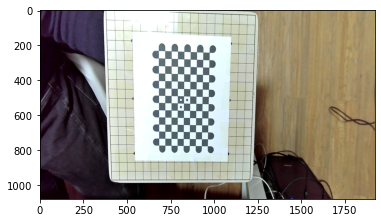

In [6]:
# 读入一个图片
frame = cv2.imread("./data/1.png")
# 图像去除畸变
img_undistor = cv2.remap(frame, remap_x, remap_y, cv2.INTER_LINEAR)
# 转换为灰度图
img_undistor_gray = cv2.cvtColor(img_undistor, cv2.COLOR_BGR2GRAY)
# 显示图像
plt.imshow(img_undistor[:, :, ::-1])
# 保存图像
cv2.imwrite("img_undistor.png", img_undistor)

## 角点检测

角点检测结果：True


True

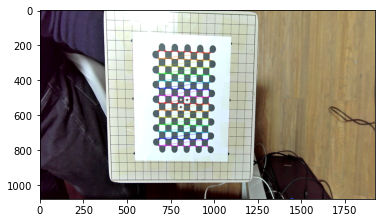

In [7]:
# 标志位
# - cv2.CALIB_CB_ACCURACY： 上采样，保证亚像素级别的精度。
# - cv2.CALIB_CB_EXHAUSTIVE: 执行一个详细的搜索，提高检出率。
# - cv2.CALIB_CB_NORMALIZE_IMAGE：图像均衡化
# meta
# - 4：在画面中出现的marker里面，最左上角的那个marker(圆) 为白底黑圆
ret, corners, meta = cv2.findChessboardCornersSBWithMeta(img_undistor_gray, (9, 14), \
        flags=cv2.CALIB_CB_ACCURACY|cv2.CALIB_CB_EXHAUSTIVE|cv2.CALIB_CB_NORMALIZE_IMAGE)

print(f"角点检测结果：{ret}")
# 绘制棋盘
canvas = cv2.drawChessboardCorners(img_undistor, (n_row, n_column), corners, patternWasFound=True)
plt.imshow(canvas[:,:, ::-1])
cv2.imwrite("chessboard_canvas.png", canvas)

## 标定板位姿态估计

In [8]:
# 3D点 为角点在标定板坐标系下的位姿
points_3d = np.float64(world_points)
# 2D点 为角点在图像上的亚像素坐标
points_2d = np.float64(corners)
# 求解PnP问题
ret, rvec, tvec, *_ = cv2.solvePnPRansac(points_3d, points_2d, \
                            M_intrisic_new, \
                            distor_coeff, \
                            flags=cv2.SOLVEPNP_ITERATIVE)
print(f"是否正确: {ret}")
print("标定板坐标系在相机坐标系下的位姿 ^{cam}_{board}T")
print(f"旋转向量:\n {rvec}")
print(f"平移向量:\n {tvec}")

# 计算T_board2cam
pose_cam2board = Pose()
pose_cam2board.set_position(*tvec.reshape(-1))
pose_cam2board.set_rotation_vector(rvec.reshape(-1))
T_cam2board = pose_cam2board.get_transform_matrix()
print("T_cam2board")
print(T_cam2board)

是否正确: True
标定板坐标系在相机坐标系下的位姿 ^{cam}_{board}T
旋转向量:
 [[ 0.1164]
 [-0.0447]
 [ 0.0249]]
平移向量:
 [[-111.4404]
 [ -70.9451]
 [ 393.2345]]
T_cam2board
[[   0.9987   -0.0274   -0.0431 -111.4404]
 [   0.0222    0.9929   -0.1167  -70.9451]
 [   0.046     0.1156    0.9922  393.2345]
 [   0.        0.        0.        1.    ]]


转换为 $x, y, z , roll, pitch, yaw$的形式, 其中xyz的单位是mm, rpy角的单位是deg

In [9]:
def pose2str(pose):
    x, y, z = pose.get_position()
    roll, pitch, yaw = [np.degrees(theta) for theta in  pose.get_euler_angle()]
    return "POSI(mm): [{:.1f},{:.1f},{:.1f}]; RPY(deg): {:.1f}, {:.1f}, {:.1f}".format(x, y, z, roll, pitch, yaw)
# 打印出来
pose2str(pose_cam2board)

'POSI(mm): [-111.4,-70.9,393.2]; RPY(deg): 6.6, -2.6, 1.3'

## 绘制标定板坐标系

True

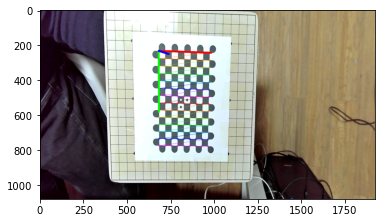

In [10]:
# 坐标轴长度( 单位 mm)
axis_length = 100.0

# 跟坐标轴相关的3D点
axis_points_3d = np.array([
    [0.0, 0.0, 0.0], 
    [axis_length,0.0, 0.0],
    [0.0, axis_length, 0.0],
    [0.0, 0.0, axis_length]], dtype="float32")

axis_points_2d, jacobian = cv2.projectPoints(axis_points_3d, 
                           rvec, tvec, M_intrisic_new, distor_coeff)

# 转换为像素坐标(整数)
axis_points_2d = axis_points_2d.reshape((-1, 2)).astype('int32')
center, axis_x, axis_y, axis_z = axis_points_2d
# 绘制坐标轴
axis_thickness = 10
cv2.line(canvas, center, axis_x, (0, 0, 255), axis_thickness)
cv2.line(canvas, center, axis_y, (0, 255, 0), axis_thickness)
cv2.line(canvas, center, axis_z, (255, 0, 0), axis_thickness)

plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
cv2.imwrite("board_draw_axis.png", canvas)

PNP求解的是$^{board}_{cam}T$